In [1]:
import openfl.native as fx
from openfl.federated import FederatedModel, FederatedDataSet
from openfl.utilities.optimizers.torch import FedProxOptimizer

## Load Dataset and Transfer 
### Define Torch Dataloader

In [2]:
from openfl.federated import FederatedModel,FederatedDataSet

from openfl.utilities.data_splitters import DirichletNumPyDataSplitter
from openfl.utilities.data_splitters import EqualNumPyDataSplitter
from openfl.utilities.data_splitters import LogNormalNumPyDataSplitter
from openfl.utilities.data_splitters import RandomNumPyDataSplitter

import DataSplitterMethods
data_splitter = DataSplitterMethods.SplitFunctionGenerator("1-Class-per-collab-Split")

import torch
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Replace here with path of your folder. 
dataset = torchvision.datasets.ImageFolder(root='/home/shivam/Documents/Gatech_Coursework/Semester 2/AIC/Final Project/content/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [3]:
print(data_splitter)

None


### Display data into train and valid sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

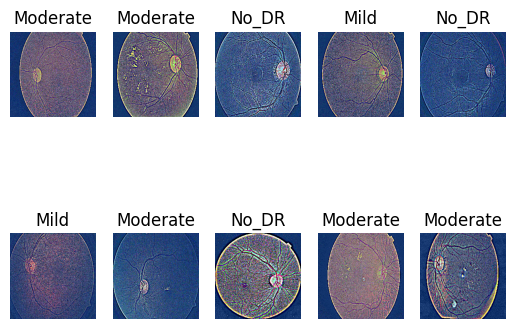

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

### Distribute data into train and valid data sets


In [6]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data, labels = next(iter(data_loader))
print("The data shape is {}".format(data.shape))

The data shape is torch.Size([3662, 3, 224, 224])


In [7]:
import torch.nn.functional as F
def split_and_return_train_valid(data, labels, split = 0.2):
  test_indices = np.random.rand(data.shape[0]) < split
  train_indices = ~test_indices
  train_data, test_data = data[train_indices], data[test_indices]
  train_labels, test_labels = labels[train_indices], labels[test_indices]
  train_labels, test_labels = F.one_hot(train_labels), F.one_hot(test_labels)
  return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = split_and_return_train_valid(data, labels) 
print("Train Data Length is {}".format(len(train_data)))
print("Test Data Length is {}".format(len(test_data)))

Train Data Length is 2954
Test Data Length is 708


In [8]:
from openfl.federated import FederatedModel,FederatedDataSet
batch_size = 16
num_classes = 5
fl_data = FederatedDataSet(train_data, train_labels, test_data, test_labels, 
                           batch_size = batch_size , num_classes = num_classes, train_splitter = data_splitter)


###  Define Model - Pretrained Model FedAVG
We can use a pretrained model like Inception or VGG Net to perform classification. These have already been pretrained on large-scale image data and we need to train only some final linear layers.

In [9]:

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class InceptionV1(nn.Module):
    def __init__(self, num_classes=5):
        super(InceptionV1, self).__init__()
        self.num_classes = num_classes
        self.inception = models.googlenet(pretrained=True)
        
        for param in self.inception.parameters():
            param.requires_grad = False
            
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return F.log_softmax(x, dim=1)
    
#     def train_epoch(self, batch_generator):
#         from openfl.federated.task import PyTorchTaskRunner
#         self.optimizer.set_old_weights([p for p in self.parameters()])
#         return PyTorchTaskRunner.train_epoch(self, batch_generator)
    
optimizer = lambda x: optim.Adam(x, lr=1e-3)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(InceptionV1())

## Earlier Parameters: 51386181

/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5125

In [11]:
net = InceptionV1()
net(data[3:8]).shape

torch.Size([5, 5])

In [ ]:
fl_model = FederatedModel(build_model=InceptionV1, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

### Define OpenFlow Plan

In [ ]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

In [ ]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

In [ ]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={"aggregator.settings.rounds_to_train": 20})

We get a model with validation score = 67% ( for 2 clients)
We get a model with validation score = 55% ( 3 epochs, 5 clients)
